# Data Loading and cleaning

In [145]:
# packages for basic python calculation
import pandas as pd
import numpy as np
import os

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for fft
import spectrum
from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# package for ploting
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import seaborn as sns

# defind function for data readin
def load_data(folder_path = "../data/sell/"):
    df_gp = pd.DataFrame()
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): 
            stock = filename[0:4]
            # print("Loading stock data:", stock, ",")
            temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
            temp_df.rename(columns={123:'rtn'}, inplace=True)
            temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
            df_gp = pd.concat([df_gp, temp_df], ignore_index=True)
            df_gp.reset_index()
            continue
        else:
            continue

    
    return df_gp

In [146]:
df_gp = load_data()

# Exam the null value and clean data

In [147]:
rows_to_drop = []
for i in range(df_gp.shape[0]):
    if sum(df_gp.iloc[i,:].isnull()):
        print("true")
        rows_to_drop.append(i)

true
true
true
true
true
true
true
true
true
true
true
true
true


Drop the rows with na values.


In [148]:
df_gp = df_gp.drop(rows_to_drop, axis=0)

In [149]:
for i in range(df_gp.shape[0]):
    if sum(df_gp.iloc[i,:].isnull()):
        print("true")
        

Also in further study, we notice that not all data are numeric type


In [153]:
df_gp.iloc[:, 1:] = df_gp.iloc[:, 1:].astype(float)

# Use the same class object to run the analysis


In [191]:
class OSC_analyzing_pipeline():
    
    """
    This class is designed and modified for the Seahorse program. It is applicable for Random Forest
    Classifier originally.
    
    Attributes:
    ----------------------------------------------------------------------------
    self.data: the input dataset that we will be using for training and testing
    self.model: the classifier we want to explore
    self.osc_gp: subset for the oscillator data
    * new addition: self.stk: subset for original stock data
    self.macd_gp: subset for the macd data
    self.rtn_gp: subset for the return values
    self.label_gp: the output for training and testing (the reponse variable)
    
    self.psd
    self.smooth
    self.first_derivitive_macd
    self.second_derivitive_macd
    self.first_derivitive_osc
    self.second_derivitive_osc
    self.partial_smooth
    
    self.feature_result_df: the feature matrix and label generated from the feature_generator function, it can be used to visual which feature is participated in model training
    self.X_train: to visual and further call the training dataset
    self.X_test: to visual and further call the test dataset
    self.y_train: to visual and further call the training dataset
    self.y_test: to visual and further call the test dataset
    
    self.report: generate the report to compare the winning rate with the original test
    The class object also contains all the attributes belongs to the model/classifier originally.
    
    Functions:
    ----------------------------------------------------------------------------
    * new addition: EDA_visualization(): function for visualization the record
    psd_calculator(): function calculate the fft values, callable with return value to be visualized
    smooth_calculator(): function for calculating the smoothness value, already modified and can handle the amplitude changes
    derivative_calculator(): function for calculating the derivitive for macd and osc
    features_generator(): function to decide which feature can be used in the final model training, the input is True/False for certain feature to be involved. In this function, all three function above will be called
    model_train(): training the model based on the feature matrix
    
    """
    
    # define the init
    def __init__(self, data):
        """
        Keyword argument:
        data -- (df) the input dataset for processing
        model -- (ML model) the classifier we are interested of, currently it is just the random forest
        """
        self.data = data
        
        # seperate indicators and returns
        # name_gp = df_gp.iloc[:, 0]
        self.osc_gp = self.data.iloc[:, 1:42]
        self.stk_gp = self.data.iloc[:, 42:83]
        self.macd_gp = self.data.iloc[:, 83:124]
        self.rtn_gp = self.data.iloc[:, 124]
        self.label_gp = np.sign(self.rtn_gp)
        self.label_gp = self.label_gp.map({1: 1, -1: 0, 0:0})
        self.results_gp = self.label_gp.map({1: 'EARN', 0: 'LOSS'})
        self.label_gp = pd.DataFrame({"label": self.label_gp})
        
    
    def EDA_visualization(self, index, osc_ind = True, stk_ind = False, macd_ind = False):
        if osc_ind:
            # plot Oscillator
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.osc_gp.iloc[index,:])
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("Oscillator")
            plt.xlabel("Time")
            plt.title("Oscillator 3-Day Time Series")
            plt.show()
        

        if stk_ind:
            # plot stock price
            plt.figure(figsize=(12,4))
            plt.plot(range(41), self.stk_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.ylabel("Stock Price")
            plt.xlabel("Time")
            plt.title("Stock Price 3-Day Time Series")
            plt.show()
    
        if macd_ind:
        # plot MACD
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.macd_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("MACD")
            plt.xlabel("Time")
            plt.title("MACD 3-Day Time Series")
            plt.show()
        
    # define function for psd calculation
    def psd_calculator(self, NFFT = 100, name = "osc"):
        """
        calculate the psd seq as new feature
        """
        freq = []
        for i in range(self.osc_gp.shape[0]):
            data_osc = self.osc_gp.iloc[i,:]
            p = Periodogram(data_osc, NFFT=NFFT)
            temp_list = list(p.psd)
            freq.append(temp_list)
        col_name = []
        for i in range(int(NFFT/2)+1):
            col_name.append("freq"+str(i))
    
        psd_df = pd.DataFrame(freq, columns=col_name)
        psd_df.index = self.osc_gp.index
        
        return psd_df
    
    # define function to calculate smoothness more directly
    def smooth_calculator(self):
        smooth_list = []
        for i in range(self.osc_gp.shape[0]):
            amp = np.mean(abs(self.osc_gp.iloc[i,:]))
            if amp == 0:
                smooth_list.append(0)
            else:
                smooth_list.append(np.var(np.diff(self.osc_gp.iloc[i,:]))/amp)
        
        smooth = pd.DataFrame(smooth_list, columns=["smooth"]) 
        smooth.index = self.osc_gp.index

        return smooth
    
    # define the function to explore the influence of partial smoothness
    def smooth_partial(self):
        # get the nearest 10 points
        osc_10 = self.osc_gp.iloc[:,-10:]
        # calculate the smoothness of 10 points
        smooth_10 = []
        for i in range(osc_10.shape[0]):
            amp = np.mean(abs(osc_10.iloc[i,:]))
            if amp == 0:
                smooth_10.append(0)
            else:
                smooth_10.append(np.var(np.diff(osc_10.iloc[i,:]))/amp)
        
        
        # get the nearest 20 points
        osc_20 = self.osc_gp.iloc[:,-20:]
        smooth_20 = []
        for i in range(osc_20.shape[0]):
            amp = np.mean(abs(osc_20.iloc[i,:]))
            if amp == 0:
                smooth_20.append(0)
            else:
                smooth_20.append(np.var(np.diff(osc_20.iloc[i,:]))/(np.mean(abs(osc_20.iloc[i,:]))))
        
        # get the nearest 30 points
        osc_30 = self.osc_gp.iloc[:,-30:]
        smooth_30 = []
        for i in range(osc_30.shape[0]):
            amp = np.mean(abs(osc_30.iloc[i,:]))
            if amp == 0:
                smooth_30.append(0)
            else:
                smooth_30.append(np.var(np.diff(osc_30.iloc[i,:]))/(np.mean(abs(osc_30.iloc[i,:]))))
        
        partial_smooth = pd.DataFrame({"smooth_10": smooth_10,
                                      "smooth_20": smooth_20,
                                      "smooth_30": smooth_30,})
        
        partial_smooth.index = self.osc_gp.index
        return partial_smooth
    
    def first_derivative_calculator(self, space = 1, name = "macd"):
        
        
        if name == "macd":
            dy = []
            for i in range(self.macd_gp.shape[0]):
                y = pd.Series(self.macd_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.macd_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.macd_gp.index
            
        if name == "osc":
            dy = []
            for i in range(self.osc_gp.shape[0]):
                y = pd.Series(self.osc_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.osc_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.osc_gp.index
            
        return deriv_df
    
    def second_derivative_calculator(self, space = 1, name = "macd"):
        
        if name == "macd":
            
            ddy = []
            for i in range(self.first_deriv_macd.shape[0]):
                y = pd.Series(self.first_deriv_macd.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_macd.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_macd.index
        
        if name == "osc":
            
            ddy = []
            for i in range(self.first_deriv_osc.shape[0]):
                y = pd.Series(self.first_deriv_osc.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_osc.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_osc.index
        
        
        return sec_deriv_df
    
    def features_generator(self, psd=True, smooth=True, curvature=True, MACD_derivative = True, partial_smooth = True):
       
    # Feature order:
    # 0-40, osc;
    # 41-81, stk;
    # 82-122: macd;
    # 123-173: freq
    # 174: smooth
    # 175-215: first derivitive of osc
    # 216-256: second derivitive of osc
    # 257-297: first derivitive of macd
    # 297-338: second derivitive of macd
    
    
        Feature_matrix = self.data.iloc[:,1:-1]
        # calculate the fft frequencies distribution for the oscillator
        if psd==True:
            self.psd_osc = self.psd_calculator(NFFT = 100)
            Feature_matrix = pd.merge(Feature_matrix, self.psd_osc, left_index=True, right_index=True)
        
        # print(Feature_matrix)
        # Feature_matrix = pd.concat([Feature_matrix, psd_osc])
    
    # Factor for smoothness
        if smooth==True:
            self.smooth_osc = self.smooth_calculator()
            Feature_matrix = pd.merge(Feature_matrix, self.smooth_osc, left_index=True, right_index=True)
        
    # Factor for curvature
        if curvature == True:
        # calculate the dy for osc (way to study curvature)
            self.first_deriv_osc = self.first_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_osc, left_index=True, right_index=True)
        # calculate the ddy for osc
            self.second_deriv_osc = self.second_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_osc, left_index=True, right_index=True)
        
    # MACD dirivative
        if MACD_derivative == True:
            # calculate the dy for macd
            self.first_deriv_macd = self.first_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_macd, left_index=True, right_index=True)
        # calculate the ddy for macd
            self.second_deriv_macd = self.second_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_macd, left_index=True, right_index=True)
        # Feature_matrix = pd.concat([Feature_matrix, first_deriv_macd,second_deriv_macd])
    
    # partial smoothness
        if partial_smooth == True:
            self.partial_smooth = self.smooth_partial()
            Feature_matrix = pd.merge(Feature_matrix, self.partial_smooth, left_index=True, right_index=True)
        
        
        self.feature_result_df = pd.merge(Feature_matrix, self.label_gp, left_index=True, right_index=True)
    
    def model_train(self, model_type = "RandomForest", n_estimators = 20, max_depth = 80):
        
        if model_type == "RandomForest":
            self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            
        Feature_matrix = self.feature_result_df.iloc[:,:-1]
        label_gp = self.feature_result_df.iloc[:,-1]
        
        #Split test set
        self.X, self.X_test, self.y, self.y_test = train_test_split(Feature_matrix, label_gp, test_size=0.2)

        #Split train/validation set
        # self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.2)
        
        self.model.fit(self.X, self.y)
        
        scores = cross_val_score(self.model, self.X, self.y, cv=5)
        
        print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print("Test Accuracy:", self.model.score(self.X_test, self.y_test))
        
        
        prob = self.model.predict_proba(self.X_test)
        # not quite familar and confortable with the log probability, just going to the normal probability
    
        # get the probbability of being 1
        proba_1 = []
        for probs in prob:
            proba_1.append(probs[1])
    
        df_result = pd.DataFrame({"predicted_prob":proba_1,
                             "true_label": self.y_test})
    
        df_count = df_result.groupby("predicted_prob").count()
        df_win = df_result.groupby("predicted_prob").sum()
    
        self.report = pd.DataFrame(df_win/df_count[["true_label"]])
        self.report["count"] = df_count
    
        self.report.columns = ["true_win_rate", "count"]
        
    #def feature_analyzing(self):
        

In [193]:
OSC_sell = OSC_analyzing_pipeline(df_gp)

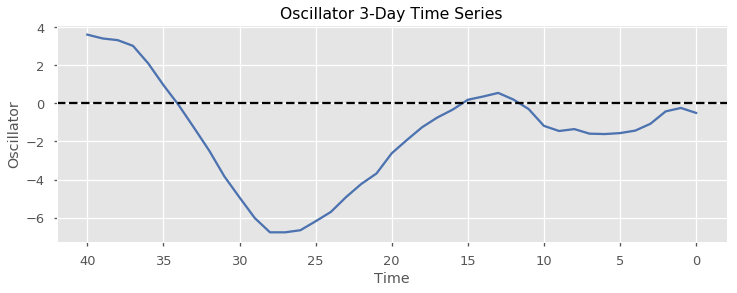

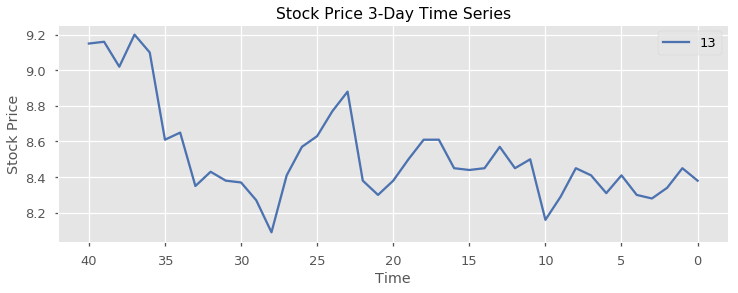

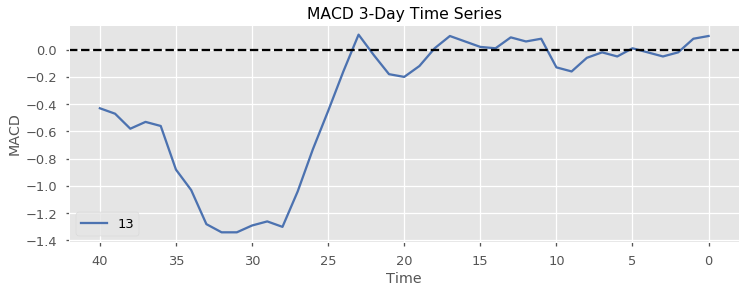

In [194]:
OSC_sell.EDA_visualization(13, True, True, True)

# Futher EDA, Explore features vs. Return



In [195]:
# generate features
OSC_sell.features_generator(True,True,True,True,True)


### Amplitude of OSC (the last point before signal)

Text(0,0.5,'Return')

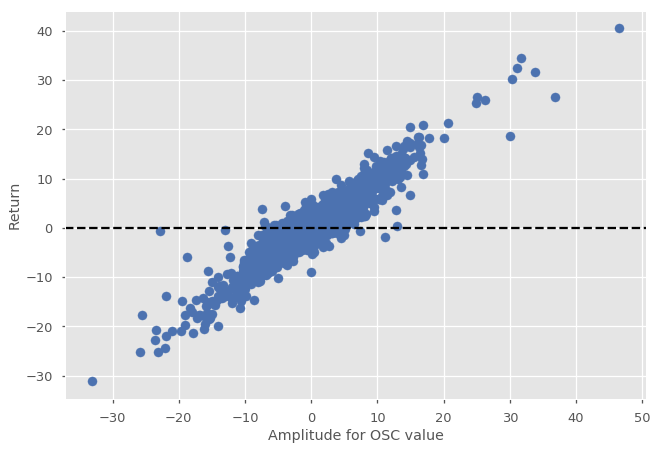

In [196]:
last_point_rec = OSC_sell.data.iloc[:,122].tolist()
return_rec = OSC_sell.data.iloc[:,123].tolist()
df_eda_amp = pd.DataFrame({"amp":last_point_rec, "rtn": return_rec})
plt.scatter(last_point_rec, return_rec)
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("Amplitude for OSC value")
plt.ylabel("Return")

We can then explore the relationship between the OSC value and the label (gain/loss) only.

In [197]:
lable_rec = OSC_sell.label_gp["label"].tolist()
df_label = pd.DataFrame({"label":lable_rec, "amp": last_point_rec})
df_label["amp"] = df_label.amp.apply(float)

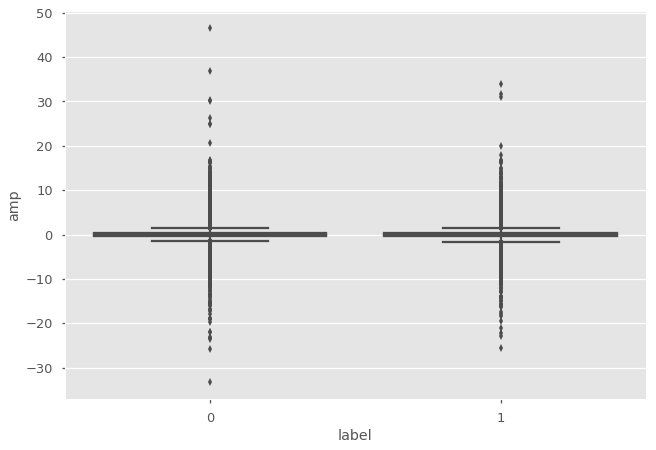

In [198]:
sns.boxplot(x = "label", y = "amp", data = df_label)

We can observe there are some outliers need to be removed

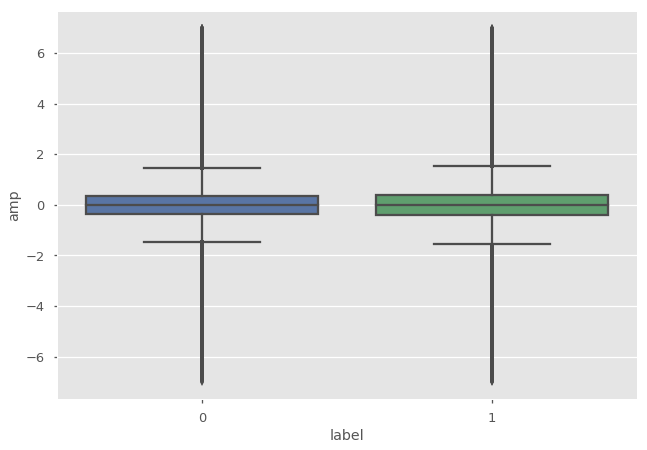

In [199]:
df_label_cleaned = df_label[abs(df_label["amp"]) < 7]
sns.boxplot(x = "label", y = "amp", data = df_label_cleaned)

## Smoothness 

In [200]:
smooth = OSC_sell.smooth_osc["smooth"].tolist()
return_rec = OSC_sell.data.iloc[:,123].tolist()

df_eda_smooth = pd.DataFrame({"smooth":smooth, "rtn": return_rec})

Text(0,0.5,'smoothness')

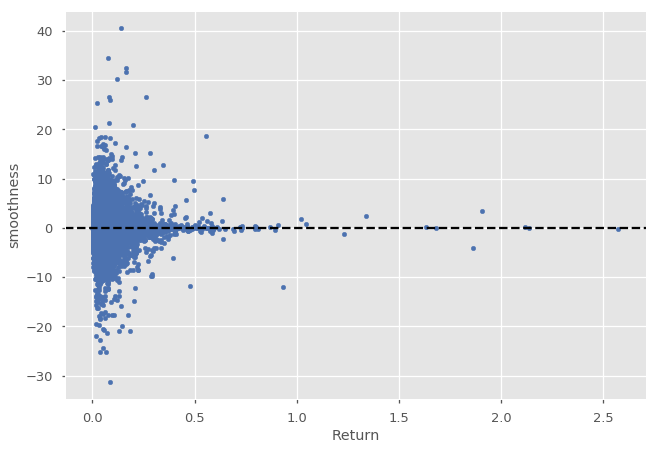

In [201]:
plt.scatter(smooth, return_rec, marker = ".")
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("Return")
plt.ylabel("smoothness")

In [202]:
# zoom in the area between 0-0.5

Text(0,0.5,'smoothness')

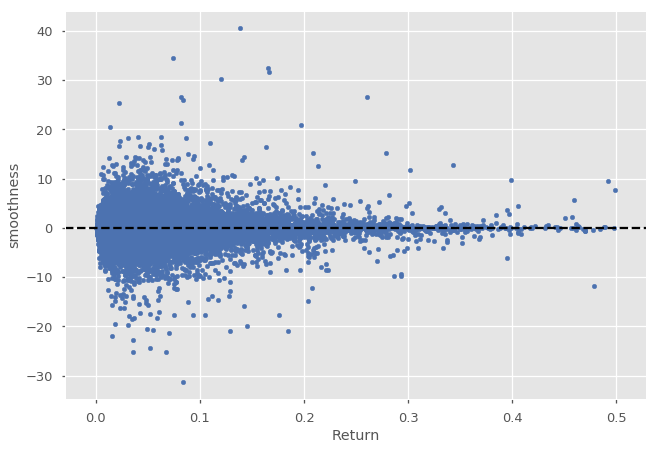

In [203]:
df_eda_smooth_zoom = df_eda_smooth[df_eda_smooth["smooth"] < 0.5]
plt.scatter(df_eda_smooth_zoom["smooth"], df_eda_smooth_zoom["rtn"], marker = ".")
plt.axhline(y = 0, color = "black", linestyle = "--")
plt.xlabel("Return")
plt.ylabel("smoothness")

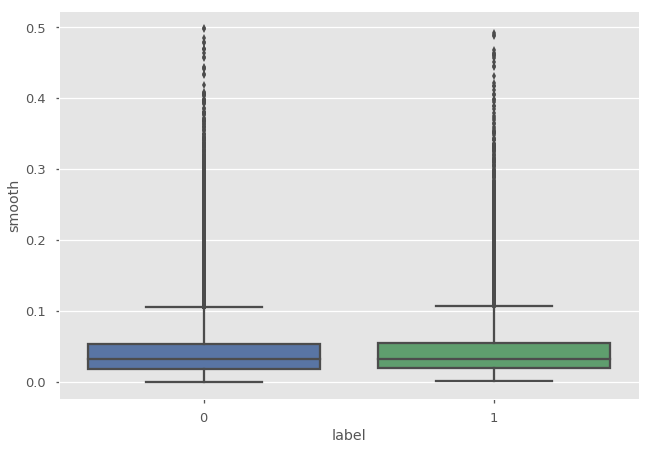

In [204]:
df_smooth_label = pd.DataFrame({"label":lable_rec, "smooth": smooth})
df_smooth_label_zoom = df_smooth_label[df_smooth_label["smooth"] < 0.5]
sns.boxplot(x = "label", y = "smooth", data = df_smooth_label_zoom)

# Modeling Exploring

In [205]:
OSC_sell.model_train("RandomForest")

Validation Accuracy: 0.57 (+/- 0.01)
Test Accuracy: 0.5658503335118555


In [207]:
OSC_sell.report

,true_win_rate,count
predicted_prob,,
0.000000,0.000000,7
0.050000,0.315789,19
0.100000,0.336842,95
0.150000,0.326797,306
0.200000,0.388021,768
0.225000,1.000000,1
0.233333,0.000000,1
0.250000,0.388926,1499
0.300000,0.390223,2291


Text(0,0.5,'True winning probability')

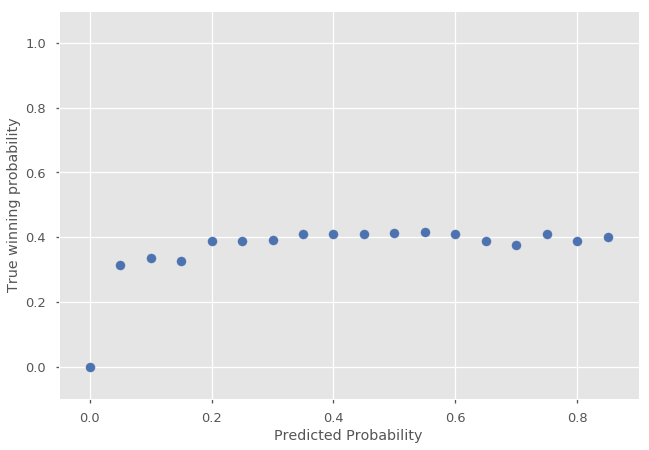

In [211]:
OSC_sell_cleaned = OSC_sell.report[OSC_sell.report["count"] > 3]
plt.scatter(OSC_sell_cleaned.index,OSC_sell_cleaned[["true_win_rate"]])
plt.ylim(-0.1, 1.1)
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

Maybe we can change the situation by hyperparameter tuning